<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_MSFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [313]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [314]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-s8hlfbt3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-s8hlfbt3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dfd9739e4bdcce166dc6326afcde41af9a5f8641_-cp36-none-any.whl size=119874 sha256=5798488ffe355a9b7af6e826485d0798a63a83a9dd1e526996fcb99d163da912
  Stored in directory: /tmp/pip-ephem-wheel-cache-zd6iqcmn/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [315]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [316]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [395]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/MSFT/df_MSFT_25drtn_features.csv')

In [396]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,41.865788,43.034542,40.031563,31.981017,-64.824174,-67.741989,-68.325831,-91.389927,50.041713,42.669514,44.472969,41.488342,-1.955907,2.148944,-1.288939,-1.886123,-3.330998,-0.465781,-0.571661,-0.536914,-0.255136,-0.991226,-0.991226,-0.991226,-0.991226,47.307086,-9.094041,-44.116469,-71.200896,-125.758917,-146.229221,0.104477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277218,0.108300,0.235336,-0.082116,0.307083,0.004476,27.549999,2.949999,4.019999,-4.363137e+06,-4.363137e+06,-4.363137e+06,-4.363137e+06,-0.165406,-0.203908,-0.183034,-0.219558,-0.144259,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,47.826094,40.235002,45.718145,35.106898,-49.748738,-52.153070,-54.751112,-87.699876,60.920745,48.041562,50.565685,41.316390,1.088143,1.014863,2.463236,0.686418,-0.889047,-0.426407,-0.551505,-0.531042,-0.261552,-0.921842,-0.921842,-0.921842,-0.921842,31.930764,-7.650264,-34.213926,-73.315369,-116.064252,-135.067341,0.733335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273121,0.077530,0.234483,-0.081353,0.297030,-0.009625,27.490000,-0.059999,0.949999,4.851032e+06,4.851032e+06,4.851032e+06,4.851032e+06,-0.109093,-0.133604,-0.129300,-0.225351,-0.148474,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,54.566730,45.782790,49.578465,32.158353,-40.703591,-43.540699,-45.871593,-85.485873,59.287152,53.149360,49.093121,41.109444,0.645850,-0.248939,3.927379,0.754307,-1.785715,-0.381584,-0.527982,-0.522776,-0.267444,-0.842617,-0.842617,-0.842617,-0.842617,73.901362,41.455439,25.070256,-34.497501,-107.850424,-125.120477,0.588234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273487,0.077594,0.228361,-0.004517,0.298416,-0.007056,29.379999,1.889999,3.099998,7.564489e+06,7.564489e+06,7.564489e+06,7.564489e+06,-0.093010,-0.117782,-0.110117,-0.231302,-0.069880,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,64.447161,57.396060,54.889495,36.822324,-2.429129,-2.429129,-2.429129,-70.356702,58.925179,59.115585,56.278644,42.996759,4.385032,6.202398,6.125410,3.171253,3.792987,-0.309431,-0.494112,-0.509082,-0.272398,-0.672824,-0.672824,-0.672824,-0.672824,166.666667,181.862307,197.810885,132.814985,-97.027289,-112.534689,0.937501,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.339431,0.102415,0.273435,0.020421,0.321756,0.013063,26.360001,-3.019999,0.840000,4.552673e+07,4.552673e+07,4.552673e+07,4.552673e+07,-0.020261,-0.018940,-0.053242,-0.205641,0.368072,2.156,0.018,0.172,0.290001,-0.380005,0.0
4,2008-03-12,51.615506,53.056046,52.325655,36.247180,-32.824464,-32.824464,-32.824464,-78.351802,50.158480,59.751385,51.747502,41.482053,-2.219951,2.726940,1.813650,1.309267,1.023285,-0.240111,-0.457893,-0.493021,-0.276705,-0.583980,-0.583980,-0.583980,-0.583980,76.200064,136.816968,147.727261,121.145361,-88.768984,-102.529325,0.094735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361883,0.102073,0.286302,0.051604,0.321833,0.008435,27.219999,0.859999,2.619999,1.388579e+07,1.388579e+07,1.388579e+07,1.388579e+07,-0.051715,-0.113685,-0.083244,-0.221880,-0.230370,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [397]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [398]:
from_date='2010-01-01'
to_date='2020-01-01'

In [399]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [400]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,71.393632,63.202470,61.326716,64.766705,-47.787727,-27.979318,-24.000041,-16.363668,77.823898,72.822326,70.628810,68.679806,0.032305,0.000000,-0.673728,1.976280,3.268844,0.223252,0.218912,0.244169,0.281295,0.449064,0.449064,0.449064,0.449064,-23.088105,-0.566587,49.138394,83.156463,47.209416,53.236178,0.695650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154032,-0.013830,0.163112,0.014023,0.156250,-0.005745,19.350000,-0.690001,-0.580000,1.368606e+06,1.368606e+06,1.368606e+06,1.368606e+06,0.156515,0.097234,0.088590,0.186999,0.295256,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,57.390212,60.506715,57.738107,61.947740,-71.568550,-37.823804,-32.444424,-24.579115,62.470388,64.633992,68.818138,67.816165,-0.613691,0.951447,-1.975148,0.819135,3.289693,0.209822,0.214629,0.240274,0.279987,0.418543,0.418543,0.418543,0.418543,-37.521595,-62.994555,24.392363,62.019997,45.740044,51.638385,0.446429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157851,-0.009022,0.162983,0.013721,0.157627,0.003620,19.160000,-0.190001,-0.850000,-2.772454e+06,-2.772454e+06,-2.772454e+06,-2.772454e+06,0.172051,0.050180,0.099441,0.171127,0.169505,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,48.118816,53.617997,56.211874,59.727456,-80.152646,-54.404097,-46.666633,-38.181790,50.221809,64.456586,67.669040,64.911152,-1.039973,-1.615509,-1.647281,-1.200516,2.975993,0.187078,0.206542,0.234640,0.278338,0.364333,0.364333,0.364333,0.364333,-129.128895,-177.378583,-51.318022,12.410045,43.908787,49.560908,0.509804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158332,-0.028914,0.165536,0.019023,0.156046,-0.003518,19.059999,-0.100000,-0.900000,-7.241332e+06,-7.241332e+06,-7.241332e+06,-7.241332e+06,0.124730,0.063452,0.096636,0.141907,-0.131014,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,47.472254,57.285873,60.666944,58.712005,-64.122175,-43.523317,-43.523317,-30.545460,53.097260,64.243148,67.969036,64.685894,0.689652,-0.968990,0.590552,-0.840880,3.197579,0.164305,0.197239,0.228285,0.276467,0.334461,0.334461,0.334461,0.334461,-53.080531,-92.403785,-29.156306,29.391119,41.622846,47.046687,0.656251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162192,-0.047268,0.166269,0.010812,0.156671,-0.004871,18.129999,-0.930000,-3.550001,-1.243753e+06,-1.243753e+06,-1.243753e+06,-1.243753e+06,0.102407,0.148970,0.081095,0.157445,0.012613,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,38.495565,51.475170,54.976226,56.256261,-89.130456,-72.352882,-63.730536,-44.727256,43.835861,61.717334,61.067142,61.274701,-1.272014,-1.624959,-2.197093,-2.354837,1.339135,0.134814,0.184597,0.220218,0.274215,0.276135,0.276135,0.276135,0.276135,-89.705084,-119.552998,-110.162829,-3.647167,39.168195,44.195691,0.234375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171202,-0.022552,0.173121,0.009665,0.160499,0.001239,17.549999,-0.580000,-2.490002,-9.767265e+06,-9.767265e+06,-9.767265e+06,-9.767265e+06,-0.017613,0.143953,0.016837,0.143485,0.342933,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [401]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,84.148053,67.616351,72.208864,76.742053,-13.235311,-9.121628,-9.121628,-5.598763,73.947854,67.246908,71.132596,67.375933,1.091771,1.758356,1.863719,3.729821,5.305063,0.218965,0.212944,0.208794,0.139993,2.424918,2.424918,2.424918,2.424918,166.666667,137.466082,146.970490,207.332184,50.249866,57.284793,0.509093,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.096289,-0.017575,0.104966,0.001749,0.114492,-0.020492,12.51,0.010000,-0.120000,3.878017e+07,3.878017e+07,3.878017e+07,3.878017e+07,0.155028,0.207635,0.224972,0.196086,1.142622,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,80.694159,71.959191,72.644194,74.921508,-13.235311,-9.121628,-9.121628,-6.818188,74.123193,74.164938,71.306969,67.161624,0.000000,1.969300,1.208773,3.997095,5.227627,0.233038,0.217974,0.211414,0.142390,2.524014,2.524014,2.524014,2.524014,88.770057,123.907912,126.704348,181.211061,51.462775,58.693955,0.164707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092400,0.009248,0.105172,0.008513,0.114516,-0.011702,12.61,0.099999,0.469999,2.585345e+07,2.585345e+07,2.585345e+07,2.585345e+07,0.127798,0.202825,0.196091,0.166893,-0.668679,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,87.696721,85.804732,70.938052,75.979955,-8.779706,-6.357720,-4.573612,-3.558482,75.319313,77.263772,67.935529,67.319483,0.182775,0.984692,2.087213,3.732708,4.359243,0.268523,0.234935,0.221122,0.149915,2.759320,2.759320,2.759320,2.759320,123.163816,109.800638,123.056812,145.845762,54.107420,61.677190,0.556394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087829,-0.011186,0.102497,0.001623,0.093192,-0.027184,13.43,0.780001,0.850000,1.356284e+07,1.356284e+07,1.356284e+07,1.356284e+07,0.072509,0.168700,0.155807,0.211714,0.268047,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,71.812839,76.782163,64.664950,71.099898,-33.793201,-21.258204,-15.193840,-11.821511,67.342260,72.252048,67.156009,67.837210,-0.861859,0.133430,0.114346,1.980196,4.102253,0.271431,0.238724,0.223878,0.152403,2.680318,2.680318,2.680318,2.680318,-29.625731,50.084015,78.824541,106.294180,53.560325,61.086342,0.375545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102531,0.006242,0.105459,0.000493,0.093226,-0.021266,14.82,1.389999,2.320000,1.576065e+06,1.576065e+06,1.576065e+06,1.576065e+06,-0.010940,0.113913,0.167101,0.227054,-0.112118,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,69.164817,74.183784,68.797849,74.282321,-31.896640,-20.065139,-14.341122,-11.315018,58.244782,66.824025,68.411468,68.871830,0.069802,-0.611332,0.184228,1.395228,5.449678,0.268132,0.240426,0.225771,0.154781,2.596653,2.596653,2.596653,2.596653,-79.728686,20.196461,55.187546,86.915493,53.661036,60.666869,0.946964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099504,0.007104,0.091607,-0.013565,0.093321,-0.021195,13.78,-1.040000,1.270000,1.724259e+06,1.724259e+06,1.724259e+06,1.724259e+06,0.028443,0.178597,0.228903,0.250066,0.123621,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [402]:
df.drop(['timestamp'], inplace=True, axis=1)

In [403]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [379]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,82.368493,71.431302,64.605968,50.067512,-6.770789,-6.770789,-6.280154,-11.068218,62.179257,62.862184,57.606590,55.077789,2.326095,5.354729,7.715408,5.712991,9.434406,0.095818,-0.039567,-0.091819,-0.054930,0.244150,0.244150,0.244150,0.244150,137.398666,233.194271,309.532534,324.785008,0.502920,-8.085162,0.781514,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.195165,0.005624,0.221419,-0.062499,0.338564,0.008544,19.540001,-1.400000,-8.089998,2.485389e+07,2.485389e+07,2.485389e+07,2.485389e+07,0.395109,0.208674,0.171145,0.092484,-0.178534,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,46.567085,44.519056,54.835869,60.991309,-47.978469,-49.277212,-53.661425,-28.201855,57.626625,43.917976,54.913021,64.060300,0.538742,-1.574491,1.739756,1.099430,1.163902,0.090286,0.194483,0.242349,0.218397,1.281318,1.281318,1.281318,1.281318,-13.370290,46.106105,22.317741,23.103314,43.053964,47.559901,0.336843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.241673,-0.022497,0.251981,0.014171,0.189355,-0.006491,14.950000,-1.360000,-3.110000,-6.020995e+05,-6.020995e+05,-6.020995e+05,-6.020995e+05,0.018871,-0.015138,-0.034087,0.161207,-0.354901,0.096,2.384186e-07,0.030,0.129997,0.529999,0.0
898,45.724892,58.212045,61.652358,51.410291,-35.766435,-37.142900,-16.049398,-16.049398,51.356515,59.524726,66.002015,57.740179,-0.990827,0.634092,-0.662740,-1.063443,8.396947,0.205252,0.171395,0.119534,0.038967,0.280646,0.280646,0.280646,0.280646,10.666796,-18.062195,-16.063605,52.572998,46.890618,49.026849,0.474997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191148,0.024439,0.225478,0.004226,0.248817,-0.009251,24.530001,-0.929998,-6.789999,2.089865e+06,2.089865e+06,2.089865e+06,2.089865e+06,0.145263,0.185178,0.186436,0.122122,-0.225470,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,51.044187,55.237414,56.194520,44.875443,-33.333333,-34.591144,-34.591144,-54.621836,52.746513,54.968912,50.570688,41.822860,2.425450,1.537246,0.507222,-1.491393,0.861391,-0.031945,-0.067315,-0.117816,-0.079022,-0.132475,-0.132475,-0.132475,-0.132475,143.312060,27.876677,25.619638,51.292443,-3.824482,-10.803613,0.510204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166347,0.037552,0.147981,0.014230,0.159831,0.009344,15.070000,-0.760000,-1.850000,9.269369e+06,9.269369e+06,9.269369e+06,9.269369e+06,0.152900,0.032555,-0.006806,-0.176918,0.584078,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,56.280680,65.364172,61.108344,53.246755,-28.420934,-24.770549,-13.567768,-14.342587,52.007039,54.666493,49.757051,46.640555,0.425396,0.491158,-0.162652,0.987171,3.542514,0.150939,0.098731,0.052888,-0.020184,0.217435,0.217435,0.217435,0.217435,70.243651,63.993486,91.962547,92.740762,27.282664,25.168787,0.270272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145352,0.018826,0.134299,-0.017414,0.195868,-0.017330,16.350000,1.170000,2.330000,1.431013e+06,1.431013e+06,1.431013e+06,1.431013e+06,0.124317,0.172694,0.095247,0.042060,0.512036,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,0.0


In [404]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [405]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     0.0
1100    0.0
Name: labels, dtype: float64

In [406]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [407]:
get_sample_weights(train_labels)

real class weights are [1.46268657 0.75968992] [0 1]
value_counts (array([0, 1]), array([ 670, 1290]))


1856    0.759690
2747    0.759690
898     1.462687
765     1.462687
1100    1.462687
          ...   
2051    0.759690
1301    1.462687
2192    1.462687
1640    1.462687
2882    0.759690
Name: labels, Length: 1960, dtype: float64

In [408]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.46268657 0.75968992] [0 1]
value_counts (array([0, 1]), array([ 670, 1290]))


In [409]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [410]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [411]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_40',
 'wr_20',
 'wr_40',
 'mfi_40',
 'roc_3',
 'roc_5',
 'roc_10',
 'roc_20',
 'trix_15',
 'trix_20',
 'trix_40',
 'kst_20',
 'kst_40',
 'vix_level',
 'forcei_10',
 'forcei_15',
 'forcei_20',
 'forcei_40',
 'cmf_10',
 'curve')

In [412]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_20',
 'wr_40',
 'mfi_10',
 'trix_15',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_15',
 'kst_20',
 'kst_40',
 'bb_l15',
 'bb_l20',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'vix_level',
 'curve',
 'dollarix_5d_change')

In [413]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_20,wr_40,mfi_10,trix_15,trix_40,macd10,macd15,macd20,macd40,cci_15,kst_20,kst_40,bb_l15,bb_l20,realised_vol_10,realised_vol_20,realised_vol_40,vix_level,curve,dollarix_5d_change
445,0.500051,0.746084,1.472032,0.838552,2.126309,0.125498,0.125498,0.125498,0.125498,0.207845,0.638336,0.707214,-0.207572,-0.202167,-0.528045,-0.605123,-0.911838,0.445087,2.013397,-0.049440
448,0.448852,0.239277,0.006561,0.719678,2.078708,-0.026781,-0.026781,-0.026781,-0.026781,-0.535614,0.520394,0.581594,-0.207572,-0.202167,-0.444245,-0.566283,-0.905570,0.226020,2.093196,-0.484604
452,0.183819,0.629128,-0.282734,0.410876,1.972358,-0.201544,-0.201544,-0.201544,-0.201544,-0.173857,0.244078,0.281247,-0.207572,-0.202167,-0.100213,-0.297818,-0.745027,0.136238,2.006838,-1.389278
469,-1.627862,-1.842680,-1.463111,-1.597233,0.979874,-1.303807,-1.303807,-1.303807,-1.303807,-0.990411,-1.687552,-1.582099,-0.207572,-0.202167,0.516350,0.543671,0.020591,1.639183,1.836308,0.935386
470,-1.513460,-1.860867,-1.898760,-1.700574,0.891028,-1.302330,-1.302330,-1.302330,-1.302330,-0.934863,-1.792512,-1.694503,-0.207572,-0.202167,0.458180,0.543442,0.020575,1.531445,1.902990,0.717803


In [414]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [415]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [416]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.4477048 , 0.5522952 ],
       [0.41060653, 0.58939344],
       [0.47725967, 0.5227403 ],
       [0.46070677, 0.5392932 ],
       [0.47173047, 0.5282696 ],
       [0.48410398, 0.51589596],
       [0.45730263, 0.54269737],
       [0.43036333, 0.5696367 ],
       [0.4731652 , 0.5268348 ],
       [0.41882768, 0.5811723 ]], dtype=float32)

In [417]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
77/79 [============================>.] - ETA: 0s - loss: 0.7277 - accuracy: 0.5097
Epoch: 0, accuracy:0.5121,  loss:0.7262,  val_accuracy:0.6122,  val_loss:0.6696,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7262 - accuracy: 0.5121 - val_loss: 0.6696 - val_accuracy: 0.6122
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6967 - accuracy: 0.5230 - val_loss: 0.6586 - val_accuracy: 0.6378
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6829 - accuracy: 0.5657 - val_loss: 0.6499 - val_accuracy: 0.5995
Epoch 4/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5561 - val_loss: 0.6368 - val_accuracy: 0.6480
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.5695 - val_loss: 0.6287 - val_accuracy: 0.6378
Epoch 6/200
79/79 [==============================] - 0s 6ms/step - loss: 0.6677 - accuracy: 0.5625 - val_loss: 0.6211 - val_accur

In [304]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.346867,0.855230,0.416171,0.793367,195
196,0.329919,0.860332,0.418169,0.775510,196
197,0.363506,0.843112,0.430488,0.778061,197
198,0.342190,0.852679,0.431234,0.790816,198
199,0.347882,0.845026,0.432464,0.775510,199


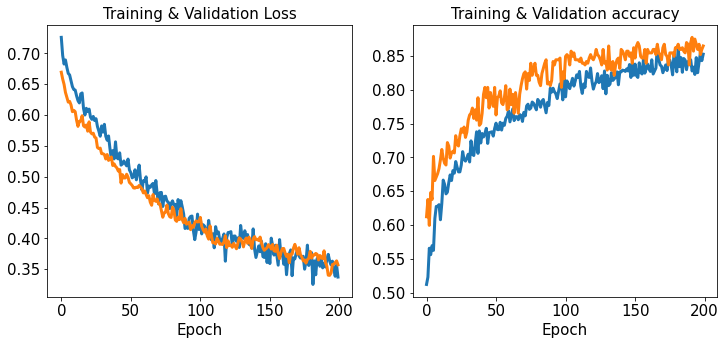

In [418]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [291]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=a0f86cafc8d2d87c3226574d6e57aa1e7d4381fcc214924ffcc0284d33e88ac0
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [419]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [420]:
shap_values  = explainer.shap_values(np.array(X_test_new))

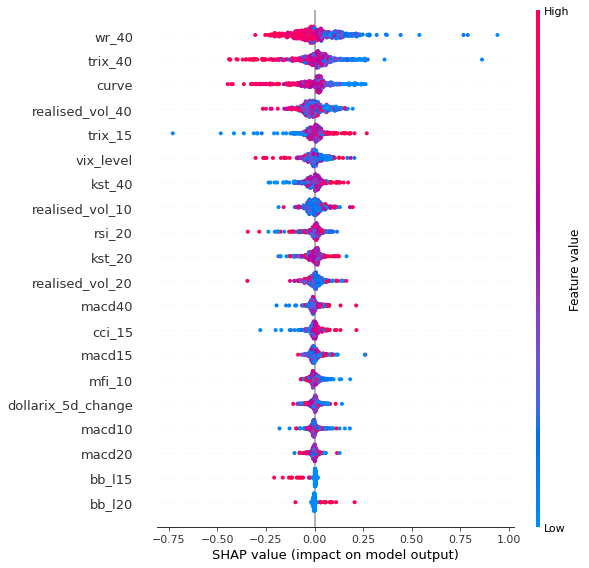

In [421]:
shap.summary_plot(shap_values[1], X_test_new)

In [422]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [423]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


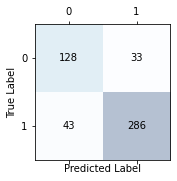

In [424]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [425]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.897
Recall: 0.869
F1: 0.883
